<h2> KOSMOS wavecals and rotation

In [2]:
%matplotlib inline
from pyvista import imred, tv, spectra
import pyvista.data
from importlib_resources import files
import numpy as np
import matplotlib.pyplot as plt
import copy

Setup pyvista Reducer, Trace, and WaveCal 

In [3]:
red=imred.Reducer('KOSMOS',dir='/home/holtz/raw/apo/oct21/UT211020',verbose=False)
trace=spectra.Trace('KOSMOS/KOSMOS_trace.fits')
wav=spectra.WaveCal('./KOSMOS_HeNe.fits')

FileNotFoundError: [Errno 2] No such file or directory: './KOSMOS_HeNe.fits'

Look at series of HeNe images taken on UT211020 at different rotator positions:
<pre>
He_Ne_rot172.6.0006.fits
He_Ne_rot124.9.0009.fits
He_Ne_rot77.5.0012.fits
He_Ne_rot29.9.0015.fits
He_Ne_rot-17.2.0018.fits
He_Ne_rot-64.4.0021.fits
He_Ne_rot-111.7.0024.fits
He_Ne_rot-158.8.0027.fits
</pre>
For each one, extract a spectrum from center of slit and get a wavelength solution, which is a 3rd order polynomial fit.

As previously noted, the differences between the wavelength solutions are more than a shift, there is a "slope" change in the solution as well, i.e. a change in the linear dispersion term. It's not totally clear if it is just a linear slope change; that describes it well at longer wavelengths, but there is some possible hint of some discrepancy at shorter wavelengths.

In any case, determine a slope of the dispersion change from the longer wavelength lines.

At the same time, measure the line widths (which are very wide!).

Plot the changes in the pixel locations relative to the first rotator position, the measured FWHM, and the slope vs mean FWHM of the red lines.



In [ ]:
fig,ax=plots.multi(1,3,figsize=(8,12))
waves=[]
pixels=[]
for im in [6,9,12,15,18,21,24,27] :
    # read and bias subtract
    hene=red.reduce(im)
    # extract
    heneec=trace.extract(hene)
    # wavelength calibrate
    wav=spectra.WaveCal('./KOSMOS_HeNe.fits')
    
    wav.identify(heneec,thresh=50,plot=None,rad=7)
    
    # save pixels of lines
    pixels.append(wav.pix)

    # plot pixel locations relative to those of first images
    lab='{:d} {:f}'.format(im,hene.header['TELROT'])
    ax[0].scatter(wav.waves,wav.pix-pixels[0],label=lab)
    # fit slope of pixel differences as f(wavelength) and plot fit
    fit=np.polyfit(wav.waves[4:],wav.pix[4:]-pixels[0][4:],deg=1)
    x=np.arange(4500,7000)
    ax[0].plot(x,fit[0]*x+fit[1])
    
    #plot FWHM of lines
    ax[1].scatter(wav.waves,wav.fwhm,label=lab)
    
    # slope vs FWHM
    ax[2].scatter(fit[0],wav.fwhm[4:].mean(),label=lab)
    
ax[0].set_ylabel('Pixel shift of line from initial rot')
ax[0].set_xlabel('Wavelength')
ax[0].legend()
ax[1].set_ylabel('FWHM of line')
ax[1].set_xlabel('Wavelength')
ax[1].legend()
ax[2].set_ylabel('FWHM of line')
ax[2].set_xlabel('Slope of pixel shift')
ax[2].set_xlim(-0.0008,0.0001)
ax[2].legend()
fig.tight_layout()


There sees to be a correlation between the dispersion change and the FWHM changes. 

Is this possibly indicative of a scale change? Could this be caused by a shift in the collimator relative to focal plane?

Check to determine whether this is actually just a fixed shift in pixels, i.e. are we getting fooled by not having a sufficiently constant dispersions so that the shift in wavelength is a fucntion of wavelength? Do this by inverting the wavelength solutions, and comparing.
<p>
Actually, we already did this above by plotting the pixels shifts, not the wavelength shifts!

In [4]:
#get inverse relation, i.e. pixels as f(wavelength)
hene=red.reduce(6)
# extract
heneec=trace.extract(hene)
# wavelength calibrate
wav6=spectra.WaveCal('./KOSMOS_HeNe.fits')
wav6.identify(heneec,thresh=50,plot=None,rad=7)
wav6.add_wave(heneec)
pix=np.arange(4096)
from scipy.interpolate import CubicSpline
wav2pix6=CubicSpline(np.flip(heneec.wave[0]),np.flip(pix))

#get inverse relation, i.e. pixels as f(wavelength)
hene=red.reduce(15)
# extract
heneec=trace.extract(hene)
# wavelength calibrate
wav15=spectra.WaveCal('./KOSMOS_HeNe.fits')
wav15.identify(heneec,thresh=50,plot=None,rad=7)
wav15.add_wave(heneec)
pix=np.arange(4096)
from scipy.interpolate import CubicSpline
wav2pix15=CubicSpline(np.flip(heneec.wave[0]),np.flip(pix))

plt.plot(np.arange(4500,7000),wav2pix6(np.arange(4500,7000))-wav2pix15(np.arange(4500,7000)))


INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  extracting ... (may take some time,
                   consider threads= if multithreading is available



FileNotFoundError: [Errno 2] No such file or directory: './KOSMOS_HeNe.fits'

OK, what about the internal cals, taken with Ne and Kr lamps?

Start by transferring wavelength solution from some other frames for a starting guess, but unfortunately having a hard time seeing Kr lines in these images, so wavelength range is limited

In [ ]:
wav=spectra.WaveCal('./KOSMOS_NeKr.fits')
#im=red.reduce(5)
#imec=trace.extract(im)
#wav.identify(imec,plot=True)

OK, now do the same analysis for the set of NeKr images
<pre>
Ne_Kr_rot172.6.0005.fits
Ne_Kr_rot124.9.0008.fits
Ne_Kr_rot77.5.0011.fits
Ne_Kr_rot29.9.0014.fits
Ne_Kr_rot-17.2.0017.fits
Ne_Kr_rot-64.4.0020.fits
Ne_Kr_rot-111.7.0023.fits
Ne_Kr_rot-158.8.0026.fits
</pre<>

INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  extracting ... (may take some time,
                   consider threads= if multithreading is available



NameError: name 'wav' is not defined

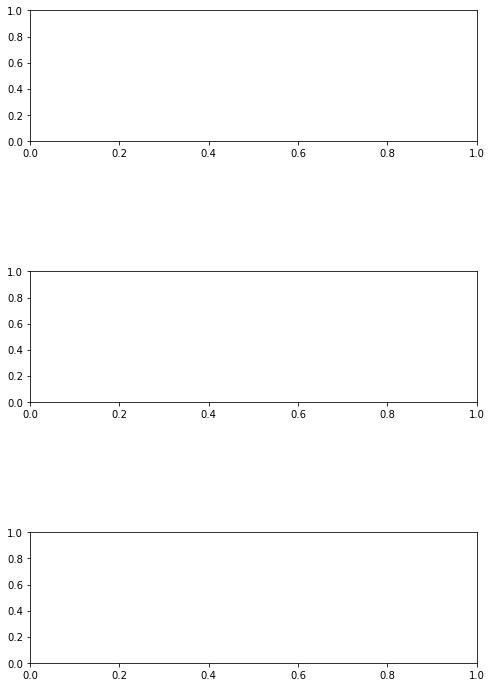

In [5]:
fig,ax=plots.multi(1,3,figsize=(8,12))
waves=[]
pixels=[]
for im in [5,8,11,14,17,20,23,26] :
    # read and bias subtract
    nekr=red.reduce(im)
    # extract
    nekrec=trace.extract(nekr)
    # wavelength calibrate
    wav.identify(nekrec,thresh=50,rad=7)
    
    # save pixels of lines
    pixels.append(wav.pix)
    lab='{:d} {:f}'.format(im,nekr.header['TELROT'])
    
    # plot pixel locations relative to those of first images
    ax[0].scatter(wav.waves,wav.pix-pixels[0],label=lab)
    # fit slope of pixel differences as f(wavelength) and plot fit
    fit=np.polyfit(wav.waves[4:],wav.pix[4:]-pixels[0][4:],deg=1)
    x=np.arange(4500,7000)
    ax[0].plot(x,fit[0]*x+fit[1])
    
    #plot FWHM of lines
    ax[1].scatter(wav.waves,wav.fwhm,label=lab)
    
    # slope vs FWHM
    ax[2].scatter(fit[0],wav.fwhm[4:].mean(),label=lab)
    
ax[0].set_ylabel('Pixel shift of line from initial rot')
ax[0].set_xlabel('Wavelength')
ax[0].legend()
ax[1].set_ylabel('FWHM of line')
ax[1].set_xlabel('Wavelength')
ax[1].legend()
ax[2].set_ylabel('FWHM of line')
ax[2].set_xlabel('Slope of pixel shift')
ax[2].set_xlim(-0.0008,0.0001)
ax[2].legend()
fig.tight_layout()


The wavelength range is limited, but it does  perhaps seem that these slope changes are not matching those for the external lamps ...

A correlation between slope and FWHm still seems to exist.

<h3> Internal vs external lamps

How do wavelength scales from internal and external lamps compare?

In [6]:
%matplotlib qt
extwav=spectra.WaveCal('./KOSMOS_HeNe.fits')
hene=red.reduce(6)
# extract
heneec=trace.extract(hene)
# wavelength calibrate
extwav.identify(heneec,thresh=50,rad=7,plot=True)


intwav=spectra.WaveCal('./KOSMOS_NeKr.fits')
nekr=red.reduce(5)
# extract
nekrec=trace.extract(nekr)
# wavelength calibrate
intwav.identify(nekrec,thresh=50,rad=7,plot=True)



FileNotFoundError: [Errno 2] No such file or directory: './KOSMOS_HeNe.fits'

NOte that NeKr doesn't have lines shortward of 5800

In [7]:
%matplotlib inline
plt.figure()
ext=extwav.wave(image=heneec.shape[1])
int=intwav.wave(image=heneec.shape[1])
plt.plot(int,ext-int)
plt.xlim(5700,7100)
plt.ylim(-5,0)
extwav.model.domain
extwav.model.c0.value

disp=extwav.model.c1.value/(extwav.model.domain[1]-extwav.model.domain[0])
print(disp)

NameError: name 'extwav' is not defined

<Figure size 432x288 with 0 Axes>

<h2> Wavelength calibration

In [54]:
%matplotlib qt

In [55]:
red=imred.Reducer('KOSMOS')
red.dir='/home/holtz/raw/apo/oct21/UT211206'
blue_int_1=red.sum([26,27,28])
blue_int_2c=red.sum([29,30,31])
blue_int_2l=red.sum([32,33,34])
blue_int_2h=red.sum([35,36,37])
red_int_1=red.sum([38,39,40])
red_int_2c=red.sum([41,42,43])
red_int_2l=red.sum([44,45,46])
red_int_2h=red.sum([47,48,49])

INSTRUMENT: KOSMOS   config: 
  will use format:  .//*{:04d}.f*.fits*
         gain:  [0.6]    rn: [ 5.]
         scale:  None   
  Biastype : 1
  Bias box: 
    SC    NC    SR    NR
  2055    43    20  4056 
  2105    43    20  4056 
  Trim box: 
    SC    NC    SR    NR
     0  2048     0  4096 
     0  2048     0  4096 
  Norm box: 
    SC    NC    SR    NR
  1000    51  2000    51 
  Reading file: /home/holtz/raw/apo/oct21/UT211206/Ne_blue_1.0026.fits
  subtracting overscan vector 
  subtracting overscan vector 
  Reading file: /home/holtz/raw/apo/oct21/UT211206/Ar_blue_1.0027.fits
  subtracting overscan vector 
  subtracting overscan vector 
  Reading file: /home/holtz/raw/apo/oct21/UT211206/Kr_blue_1.0028.fits
  subtracting overscan vector 
  subtracting overscan vector 
  combining data with sum....
  calculating uncertainty....
  Reading file: /home/holtz/raw/apo/oct21/UT211206/Ne_blue_2c.0029.fits
  subtracting overscan vector 
  subtracting overscan vector 
  Reading file: /h

In [57]:
wav=spectra.WaveCal('KOSMOS/KOSMOS_blue_waves.fits')
ims=[blue_int_1,blue_int_2c, blue_int_2l, blue_int_2h]
lags=[range(-100,100),range(-100,100),range(-600,-550),range(550,600)]
for im,lag in zip(ims,lags) :
    arcec=trace.extract(im)
    tmp=copy.deepcopy(wav)
    tmp.identify(arcec,thresh=20,plot=True,rad=5,lags=lag,file='henearkr.dat')
    tmp.weights[:] = 1.
    tmp.identify(arcec,thresh=20,plot=True,rad=5,lags=range(-50,50),file='henearkr.dat')

  rms:    1.124 Angstroms (26 lines)



/home/local/Anaconda3-2020.02/envs/py3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


  See identified lines.
  rms:    7.502 Angstroms (84 lines)
  Input in plot window: 
       l : to remove all lines to left of cursor
       r : to remove all lines to right of cursor
       n : to remove line nearest cursor x position
       anything else : finish and return
  rms:    7.502 Anstroms
  input from plot window...
  rms:    1.790 Anstroms
  input from plot window...
  rms:    1.764 Anstroms
  input from plot window...
  rms:    1.752 Anstroms
  input from plot window...
  rms:    1.758 Anstroms
  input from plot window...
  rms:    1.738 Anstroms
  input from plot window...
  rms:    1.725 Anstroms
  input from plot window...
  rms:    1.659 Anstroms
  input from plot window...
  rms:    1.600 Anstroms
  input from plot window...
  rms:    1.496 Anstroms
  input from plot window...
  rms:    1.413 Anstroms
  input from plot window...
  rms:    1.326 Anstroms
  input from plot window...
  rms:    1.208 Anstroms
  input from plot window...
  rms:    1.184 Anstroms
  input 

/home/local/Anaconda3-2020.02/envs/py3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


  See identified lines.
  rms:    7.502 Angstroms (84 lines)
  Input in plot window: 
       l : to remove all lines to left of cursor
       r : to remove all lines to right of cursor
       n : to remove line nearest cursor x position
       anything else : finish and return
  rms:    7.502 Anstroms
  input from plot window...
  rms:    1.790 Anstroms
  input from plot window...




/home/local/Anaconda3-2020.02/envs/py3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


  See identified lines.
  rms:    2.532 Angstroms (84 lines)
  Input in plot window: 
       l : to remove all lines to left of cursor
       r : to remove all lines to right of cursor
       n : to remove line nearest cursor x position
       anything else : finish and return
  rms:    2.532 Anstroms
  input from plot window...



/home/local/Anaconda3-2020.02/envs/py3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


  See identified lines.
  rms:    2.559 Angstroms (84 lines)
  Input in plot window: 
       l : to remove all lines to left of cursor
       r : to remove all lines to right of cursor
       n : to remove line nearest cursor x position
       anything else : finish and return
  rms:    2.559 Anstroms
  input from plot window...




/home/local/Anaconda3-2020.02/envs/py3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


  See identified lines.
  rms:   10.915 Angstroms (87 lines)
  Input in plot window: 
       l : to remove all lines to left of cursor
       r : to remove all lines to right of cursor
       n : to remove line nearest cursor x position
       anything else : finish and return
  rms:   10.915 Anstroms
  input from plot window...
  rms:    3.263 Anstroms
  input from plot window...



/home/local/Anaconda3-2020.02/envs/py3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


  See identified lines.
  rms:    3.304 Angstroms (87 lines)
  Input in plot window: 
       l : to remove all lines to left of cursor
       r : to remove all lines to right of cursor
       n : to remove line nearest cursor x position
       anything else : finish and return
  rms:    3.304 Anstroms
  input from plot window...




/home/local/Anaconda3-2020.02/envs/py3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


  See identified lines.
  rms:   25.771 Angstroms (79 lines)
  Input in plot window: 
       l : to remove all lines to left of cursor
       r : to remove all lines to right of cursor
       n : to remove line nearest cursor x position
       anything else : finish and return
  rms:   25.771 Anstroms
  input from plot window...
  rms:   24.851 Anstroms
  input from plot window...
  rms:   24.668 Anstroms
  input from plot window...
  rms:   21.084 Anstroms
  input from plot window...
  rms:    3.268 Anstroms
  input from plot window...



/home/local/Anaconda3-2020.02/envs/py3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


  See identified lines.
  rms:   27.561 Angstroms (79 lines)
  Input in plot window: 
       l : to remove all lines to left of cursor
       r : to remove all lines to right of cursor
       n : to remove line nearest cursor x position
       anything else : finish and return
  rms:   27.561 Anstroms
  input from plot window...



In [58]:
wav=spectra.WaveCal('KOSMOS/KOSMOS_red_waves.fits')
ims=[red_int_1,red_int_2c, red_int_2l, red_int_2h]
lags=[range(-100,100),range(-100,100),range(-600,-550),range(550,600)]
for im,lag in zip(ims,lags) :
    arcec=trace.extract(im)
    tmp=copy.deepcopy(wav)
    tmp.identify(arcec,thresh=100,plot=True,rad=20,lags=lag)
    tmp.weights[:] = 1.
    tmp.identify(arcec,thresh=100,plot=True,rad=10)   

  rms:    1.505 Angstroms (50 lines)



/home/local/Anaconda3-2020.02/envs/py3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


  See identified lines.
  rms:   33.953 Angstroms (42 lines)
  Input in plot window: 
       l : to remove all lines to left of cursor
       r : to remove all lines to right of cursor
       n : to remove line nearest cursor x position
       anything else : finish and return
  rms:   33.953 Anstroms
  input from plot window...
  rms:    7.608 Anstroms
  input from plot window...
  rms:    6.915 Anstroms
  input from plot window...
  rms:    6.427 Anstroms
  input from plot window...
  rms:    5.747 Anstroms
  input from plot window...
  rms:    4.111 Anstroms
  input from plot window...
  rms:    3.552 Anstroms
  input from plot window...
  rms:    3.431 Anstroms
  input from plot window...
  rms:    1.449 Anstroms
  input from plot window...
  rms:    1.244 Anstroms
  input from plot window...
  rms:    1.119 Anstroms
  input from plot window...
  rms:    0.202 Anstroms
  input from plot window...

  See identified lines.
  rms:    1.781 Angstroms (42 lines)
  Input in plot window: 

/home/local/Anaconda3-2020.02/envs/py3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


  See identified lines.
  rms:   21.404 Angstroms (38 lines)
  Input in plot window: 
       l : to remove all lines to left of cursor
       r : to remove all lines to right of cursor
       n : to remove line nearest cursor x position
       anything else : finish and return
  rms:   21.404 Anstroms
  input from plot window...
  rms:   21.541 Anstroms
  input from plot window...
  rms:   21.474 Anstroms
  input from plot window...

  See identified lines.
  rms:    5.691 Angstroms (38 lines)
  Input in plot window: 
       l : to remove all lines to left of cursor
       r : to remove all lines to right of cursor
       n : to remove line nearest cursor x position
       anything else : finish and return
  rms:    5.691 Anstroms
  input from plot window...


  See identified lines.
  rms:   14.548 Angstroms (36 lines)
  Input in plot window: 
       l : to remove all lines to left of cursor
       r : to remove all lines to right of cursor
       n : to remove line nearest cursor x p

/home/local/Anaconda3-2020.02/envs/py3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


  See identified lines.
  rms:   80.145 Angstroms (34 lines)
  Input in plot window: 
       l : to remove all lines to left of cursor
       r : to remove all lines to right of cursor
       n : to remove line nearest cursor x position
       anything else : finish and return
  rms:   80.145 Anstroms
  input from plot window...



In [ ]:
tmp.weights[:] = 0.
tmp.weights



In [ ]:
wav=spectra.WaveCal('KOSMOS/KOSMOS_blue_waves.fits')
arcec=trace.extract(blue_int_1)
wav.identify(arcec,thresh=20,plot=True)
fw_blue_1=wav.fwhm

In [ ]:
arcec=trace.extract(blue_int_2c)
wav.identify(arcec,thresh=20,plot=True)
fw_blue_2cent=wav.fwhm

In [ ]:
tmp=copy.deepcopy(wav)
arcec=trace.extract(blue_int_2l)
tmp.identify(arcec,thresh=20,plot=True,lags=range(-600,-550))

In [ ]:
tmp=copy.deepcopy(wav)
arcec=trace.extract(blue_int_2h)
tmp.identify(arcec,thresh=20,plot=True,lags=range(550,600))

In [ ]:
plt.figure()
plt.plot(wav.waves,fw_blue_1,'bo')
plt.plot(wav.waves,fw_blue_2cent,'go')

In [ ]:
wav=spectra.WaveCal('KOSMOS/KOSMOS_red_waves.fits')
wav=spectra.WaveCal(degree=3)
arcec=trace.extract(red_int_1)
wref=[7032,2465]
disp=-0.99
wav.identify(arcec,thresh=50,plot=True,rad=5,inter=True,file='henearkr.dat')

In [ ]:
wav.identify(arcec,file='henearkr.dat',thresh=50,plot=True,rad=3)
#wav.write('KOSMOS_red_waves.fits')

In [ ]:
tmp=copy.deepcopy(wav)
arcec=trace.extract(red_int_2c)
tmp.identify(arcec,plot=True)

In [ ]:
tmp=copy.deepcopy(wav)
arcec=trace.extract(red_int_2l)
tmp.identify(arcec,plot=True,lags=range(-600,-550))

In [ ]:
tmp.identify(arcec,rad=3,plot=True,file='henearkr.dat')

In [ ]:
wav.identify(arcec,file='henearkr.dat',rad=3,thresh=100,plot=True)

In [ ]:
wav.write('KOSMOS_red_1.fits')


<h2> 1.18 arcsec slit

In [ ]:
red=imred.Reducer('KOSMOS',dir='/home/holtz/raw/apo/oct21/Q4NM01/UT211031/kosmos',verbose=True)
trace=spectra.Trace('KOSMOS/KOSMOS_trace.fits')
wav=spectra.WaveCal('./KOSMOS_HeNe.fits')

In [ ]:
arc=red.sum([14,15,16])
arcec=trace.extract(arc,plot=t)

In [ ]:
#%matplotlib qt
#t=tv.TV()
t.tv(arc)

In [ ]:
#plt.figure()
plt.clf()
plt.plot(arcec.data[0])
plt.plot(wav.spectrum[0],color='r')
#plt.clf()
#plt.plot(arcec.data[0]/arcec.uncertainty.array[0])
print(wav.waves)
print(wav.pix)

In [ ]:
wav=spectra.WaveCal('KOSMOS/KOSMOS_blue_waves.fits')
wav.identify(arcec,thresh=20,
            fit=True,plot=True,pixplot=True,rad=20)